## Defining the problem

**What is Writer’s Block?**
- Defined as “the inability to begin or continue writing for reasons other than a lack of basic skill or commitment.”
- Personal Experience: Can be very frustrating, caused me sleepless nights when I was affected by it. Can also happen to artists.
- Put plainly, it is a sudden lack of motivation which results in writers being unable to continue their work.

**Storyboarding, and how writer’s block has a negative effect:**
- Crucial step where creators plan the visual flow of the story, depicting scenes and panel layouts.
- Storyboarding is the bridge between a written script and the final artwork.
- Writer's block can extend to storyboarding, where creators struggle to visualize the scenes and transitions

**Writer’s Block is prevalent in the manga industry:**
- Berserk: Kentaro Miura was known for taking hiatuses due to creative challenges leading to long waits.
- Evangelion: Yoshiyuki Sadamoto took multiple hiatuses which were attributed to creative challenges.
- Hunter X Hunter: Yoshihiro Togashi, experienced writer's block, leading to year-long hiatuses.

**Creators’ relentless workload is worsening the issue:**
- There are many manga creators who end up suffering from their work
- Creators work long hours affecting physical or mental health or suffer direct abuse from the system.
- Leads to a loss of motivation, inability to produce new ideas, and worsens the problem of writer’s block.

**How is AI helping with writer's block?**
- ChatGPT is helping to write next instalment of manga hit One Piece as author runs into writer’s block.
- “Cyberpunk: Peach John” is the world’s first complete AI manga work.

We thus arrive at the following problem statement:

## Problem Statement
“Can we build AI Models that address the problem of writer’s block in the manga industry by helping with ideation and storyboarding?”

## Contents:
- [Data Cleaning](#data-cleaning)
  - [Dealing with Duplicates](#dealing-with-duplicates)
  - [Checking for Null Values](#checking-for-null-values)
  - [Cleaning up the Descriptions](#cleaning-up-the-descriptions) <br>
  
- [EDA: Exploring the Data for Interesting Insights](#eda-exploring-the-data-for-interesting-insights)
  - [Visualizing Outliers in the Dataset](#visualizing-outliers-in-the-dataset)
  - [Is there a Relation between Number of Members and Rating?](#is-there-a-relation-between-number-of-members-and-rating)
  - [Computing Summary of Ratings and Number of Members by Genres](#computing-summary-of-ratings-and-number-of-members-by-genres)
  - [Visualizing the Averages with Bar Graphs](#visualizing-the-averages-with-bar-graphs)
  - [Exploring Keywords in the Popular Genres](#exploring-keywords-in-the-popular-genres) <br>
  
- [Conclusions from the Exploratory Data Analysis (EDA)](#conclusions-from-the-exploratory-data-analysis-eda)
- [Recommendations and Action Points](#recommendations-and-action-points)


## Dataset Used:
- manga_data.csv

# Data Cleaning 
Now that we have our data in a consolidated CSV, let us undertake a few cleaning steps. The cleaning steps will be as follows:
- Devising a strategy of dealing with duplicates
- Checking for null values
- Removing any unwanted text from the descriptions

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# Loading and checking the dataset
df = pd.read_csv('../data/manga_data.csv')
df.head()

,Name,Description,Rating,Members,Primary Genre
0,Berserk,"Guts, a former mercenary now known as the ""Bla...",9.47,660000,Action
1,Shingeki no Kyojin,"Hundreds of years ago, horrifying creatures wh...",8.55,642000,Action
2,One Piece,"Gol D. Roger, a man referred to as the ""King o...",9.22,595000,Action
3,Chainsaw Man,Denji has a simple dream—to live a happy and p...,8.74,586000,Action
4,Tokyo Ghoul,Lurking within the shadows of Tokyo are fright...,8.52,488000,Action


### Dealing with duplicates
A key question needs to be answered before proceeding. How do we deal with duplicates? This is more complicated and subjective than one might think. Let us take the manga 'Berserk' for instance.

In [3]:
# Assuming your DataFrame is named df
filtered_df = df[df['Name'] == 'Berserk']
filtered_df

,Name,Description,Rating,Members,Primary Genre
0,Berserk,"Guts, a former mercenary now known as the ""Bla...",9.47,660000,Action
3000,Berserk,"Guts, a former mercenary now known as the ""Bla...",9.47,660000,Fantasy
4000,Berserk,"Guts, a former mercenary now known as the ""Bla...",9.47,660000,Drama
5000,Berserk,"Guts, a former mercenary now known as the ""Bla...",9.47,660000,Supernatural
9000,Berserk,"Guts, a former mercenary now known as the ""Bla...",9.47,660000,Horror


Here is where domain knowledge plays a part. Having read the story and having been a fan of it for a long time, an argument can be made to place Berserk in any one of the genres. Thus, in my subjective opinion, Berserk should not be deleted from any of the items. If time was not a constraint, each duplicate should be looked at on a case-by-case basis to determine which genre it best fits in. <br>
However, due to time constraints, the approach taken here is to not delete any duplicates, as similar arguments can be made for a lot of the duplicates in the dataset. It is usually rare for manga's to stick to a single genre, and the majority of mangas span multiple genres, thus giving further credence to our approach of keeping the duplicates.

### Checking for null values
Now that we have dealt with the duplicates, let us check the data for null values.

In [4]:
# Checking and printing out null values
null_counts = df.isnull().sum()

print(null_counts)

Name               0
Description        0
Rating           123
Members            0
Primary Genre      0
dtype: int64


In [5]:
# Let us try to see which genres have null values
rows_with_null_rating = df[df['Rating'].isnull()]

# Get distinct primary genres with null ratings
distinct_genres_with_null_rating = rows_with_null_rating['Primary Genre'].unique()

print(distinct_genres_with_null_rating)

['SciFi' 'Mystery' 'Horror']


We can see that SciFi, Mystery, and Horror genres have some null ratings. How do we deal with these? One approach could be to simply replace these values with 0. While this is valid, it would skew the summary statistics a little. The ratings on MAL are aggregated and averaged based on a large number of reviews, thus it is more accurate to first calculate the average ratings for these 3 genres without the null values and then replace the nulls with the average. A third valid approach could also be to delete these null values as there aren't that many of them. However, this would create a class imbalance while training the model, so the second method of computing averages is preferred.

In [6]:
# Calculate the average rating for each distinct genre with null ratings
genre_avg_ratings = {}
for genre in distinct_genres_with_null_rating:
    # Filter the DataFrame to include only rows with the current genre and non-null ratings
    non_null_ratings = df[(df['Primary Genre'] == genre) & (~df['Rating'].isnull())]
    
    # Calculate the average rating for the current genre
    avg_rating = non_null_ratings['Rating'].mean()
    
    genre_avg_ratings[genre] = avg_rating

# Fill null ratings with genre-specific average values
for genre in genre_avg_ratings:
    df.loc[(df['Rating'].isnull()) & (df['Primary Genre'] == genre), 'Rating'] = genre_avg_ratings[genre]

In [7]:
# Checking and printing out null values
null_counts = df.isnull().sum()

print(null_counts)

Name             0
Description      0
Rating           0
Members          0
Primary Genre    0
dtype: int64


We have thus dealt with all null values.

### Cleaning up the descriptions
The descriptions are fine for the most part, however, a lot of them contain this text: [Written by MAL Rewrite]. This text needs to be removed from the descriptions.

In [8]:
# Remove "[Written by MAL Rewrite]" from descriptions
df['Description'] = df['Description'].str.replace(r'\[Written by MAL Rewrite\]', '', regex=True)

This marks the end of data cleaning. Now, we will explore the data for insights.

# EDA: Exploring the data for interesting insights
Now that we have a clean dataset, let us explore it for insights. The theme of our problem statement is dealing with writer's block. This EDA will focus on more of a business/commercial angle to provide a holistic view and recommendation. From a commercial perspective, writers will want to know one key thing. 'What is popular with the crowd?' 

We have 2 things that give us an indication of popularity: The ratings and the number of members on MAL for each manga. The higher the number of members, the more likely the manga is popular and thus will sell well. Ratings are more of an indicator of quality or enjoyment, but we can still explore which genres tend to get higher ratings. A higher rating will make the manga look more attractive to users who have not yet read the manga, thus increasing the chance that the manga will acquire new fans and members. Some of the key questions that the EDA looks to answer are as follows:
- Are there any outliers in the ratings and members columns?
- Is there a correlation between the ratings and number of members?
- Which manga genres have the highest average rating and number of members?
- What are some of the top keywords used to describe the most popular manga genres?

This EDA will also inform feature selection, as our model will only be trained on the top 3-4 most popular genres. The section will conclude with some recommendations and action points to new and aspiring manga writers.

### Visualising outliers in the dataset
Box plots will be used for this purpose.

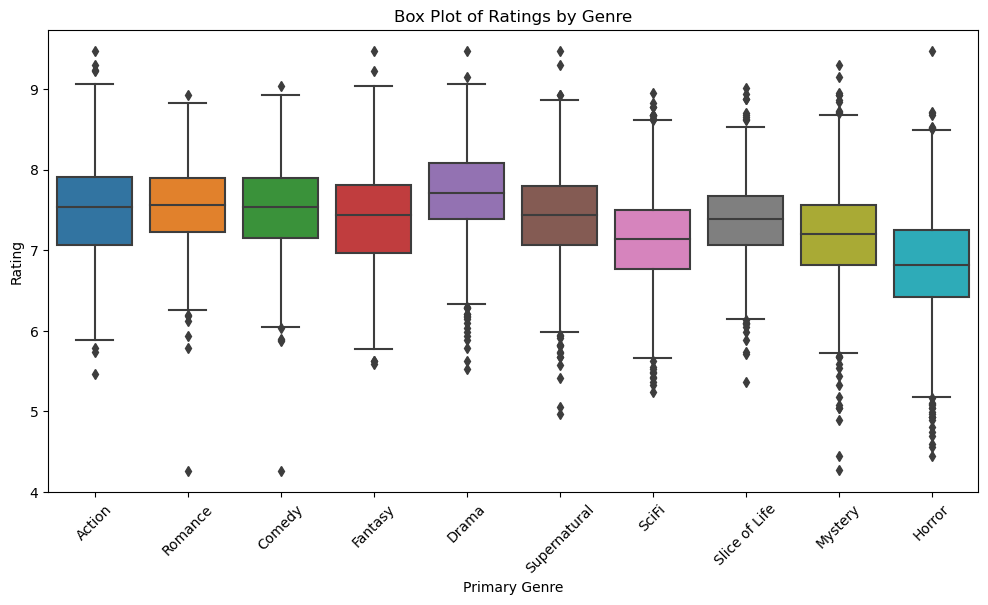

In [9]:
# Create box plots grouped by genre for ratings
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Primary Genre', y='Rating')
plt.title('Box Plot of Ratings by Genre')
plt.xticks(rotation=45)
plt.show()

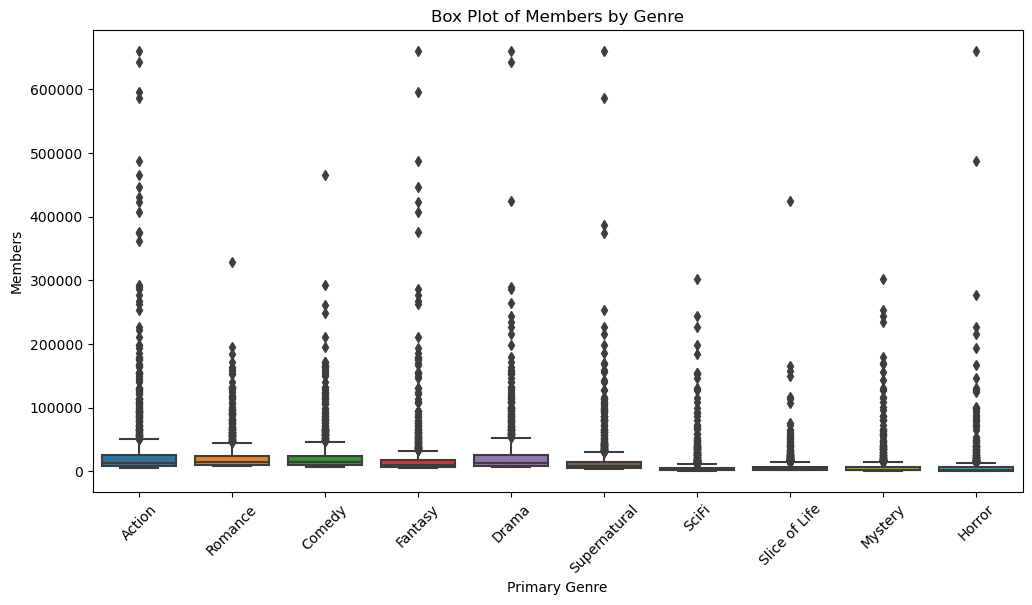

In [10]:
# Create box plots grouped by genre for number of members
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Primary Genre', y='Members')
plt.title('Box Plot of Members by Genre')
plt.xticks(rotation=45)
plt.show()

### Comments about the outliers
It is clear that the dataset has outliers, especially in the number of members. The ratings are comparatively balanced, but there are a lot of outliers in the number of members. 

This is as some of the more mainstream manga, which also subsequently get anime adaptations and have been running on for a long time, are more visible to the public, thus increasing their member base. For instance, Attack on Titan, which has been popular for over a decade, will obviously have a much larger member base than something like The Great Cleric, which is a relatively newer manga. 

This is also why the member base is a good indicator of popularity. As for dealing with the outliers, we should retain and keep them in our calculations, as these will be vital indicators of popularity.

### Is there a relation between number of members and rating?

Correlation coefficient between Rating and Members: 0.3888019262052969


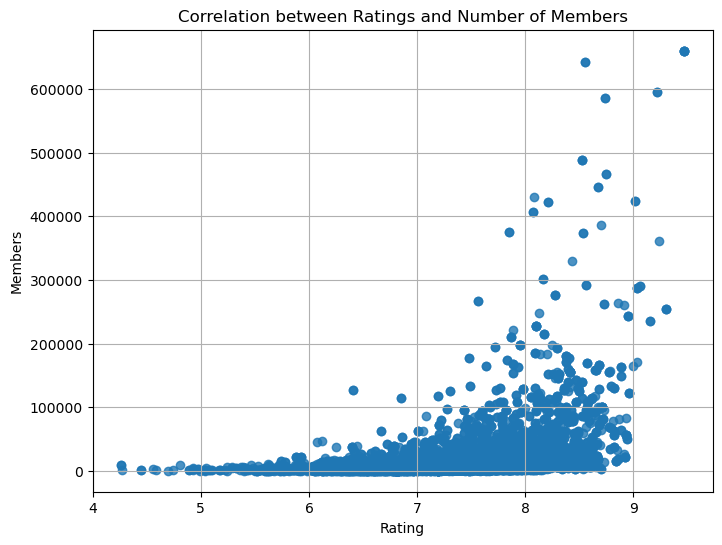

In [11]:
# Calculate the correlation coefficient between 'Rating' and 'Members'
correlation_coefficient = df['Rating'].corr(df['Members'])

print(f'Correlation coefficient between Rating and Members: {correlation_coefficient}')
# Create a scatter plot to visualize the correlation between ratings and members
plt.figure(figsize=(8, 6))
plt.scatter(df['Rating'], df['Members'], alpha=0.8)
plt.title('Correlation between Ratings and Number of Members')
plt.xlabel('Rating')
plt.ylabel('Members')
plt.grid(True)
plt.show()

As seen in the visualisation and the statement, there is a modest positive correlation between the number of members and the rating. This could mean that, atleast in some cases, higher the number of members, higher is the rating. Intuitively, this makes sense too. A larger fanbase indicates that there are there are more people who can give the manga a high rating.

However, the strength of the correlation is only modest, which suggests that this relation is true only in some cases. There could also be an opposite effect in order, where people do not like what is mainstream and give the manga a low score.

### Computing Summary of Ratings and Number of Members by Genres
To compute a summary table of average members and ratings by genre, let us first create a dataframe with the required columns. The average will be used to compute summary statistics as it takes into account the effect of the outliers.

In [12]:
# Group 'Primary Genre' and calculate the mean for numeric columns
numeric_data = df.select_dtypes(include=['float64', 'int'])
numeric_data['Primary Genre'] = df['Primary Genre']

mean_numeric_data_by_genre = numeric_data.groupby('Primary Genre').mean()

# Display the result
mean_numeric_data_by_genre

,Rating,Members
Primary Genre,,
Action,7.490600,32027.400
Comedy,7.516560,24292.300
Drama,7.704210,26791.100
Fantasy,7.394980,21961.400
Horror,6.817446,8777.903
Mystery,7.196698,9063.533
Romance,7.537200,23244.700
SciFi,7.140581,8604.158
Slice of Life,7.372700,8200.300


### Comments and inferences about the summary statistics
The table displays the average ratings and the average number of members for each manga genre. It is evident that different genres have distinct characteristics, as reflected in these averages.  The 'Members' column shows the average number of members per genre. Genres such as 'Action,' 'Comedy,' and 'Drama' tend to have a higher number of members, suggesting they are more popular among the audience. On the other hand, genres like 'Horror,' 'Mystery,' and 'SciFi' have relatively lower average membership.

The 'Rating' column indicates the average ratings per genre. The average ratings for the genres span from approximately 6.8 to 7.7. Genres like 'Drama,' 'Comedy,' and 'Romance' tend to have higher average ratings, suggesting that they are well-received by the audience. In contrast, 'Horror' and 'SciFi' have slightly lower average ratings, which may indicate that these genres are more polarizing, with a mix of highly-rated and lower-rated works. This effect can also be seen to an extent on the box plots. 

As explored in the correlation section, the correlation between genre popularity and rating varies across genres. Some genres with higher popularity also tend to have higher ratings ('Action' and 'Comedy'), while others may not necessarily follow this pattern ('Horror' and 'SciFi'). This suggests that audience preferences are diverse, and a genre's popularity doesn't always equate to higher average ratings.

### Visualising the averages with bar graphs
Bar graphs will help us better understand the number of members and ratings by genres in a visual manner.

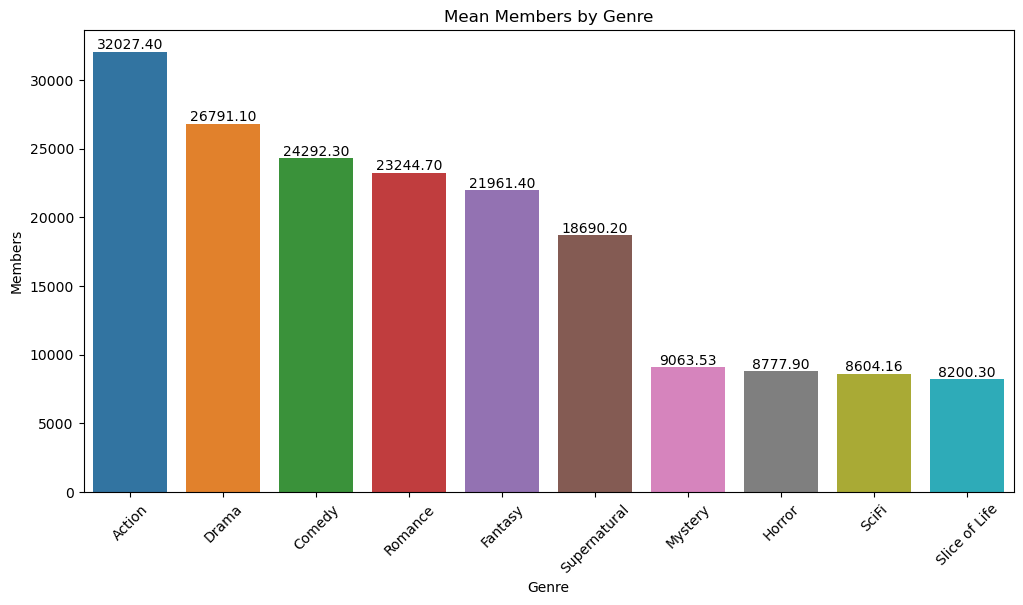

In [13]:
# Sort the DataFrame by 'Members' in descending order
mean_numeric_data_by_genre = mean_numeric_data_by_genre.sort_values(by= 'Members', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=mean_numeric_data_by_genre.index, y='Members', data=mean_numeric_data_by_genre)
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('Members')
plt.title('Mean Members by Genre')

# Annotate the bars with the values (up to 2 decimal places) positioned higher
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.01), ha='center', va='bottom', fontsize=10, color='black')

plt.show()

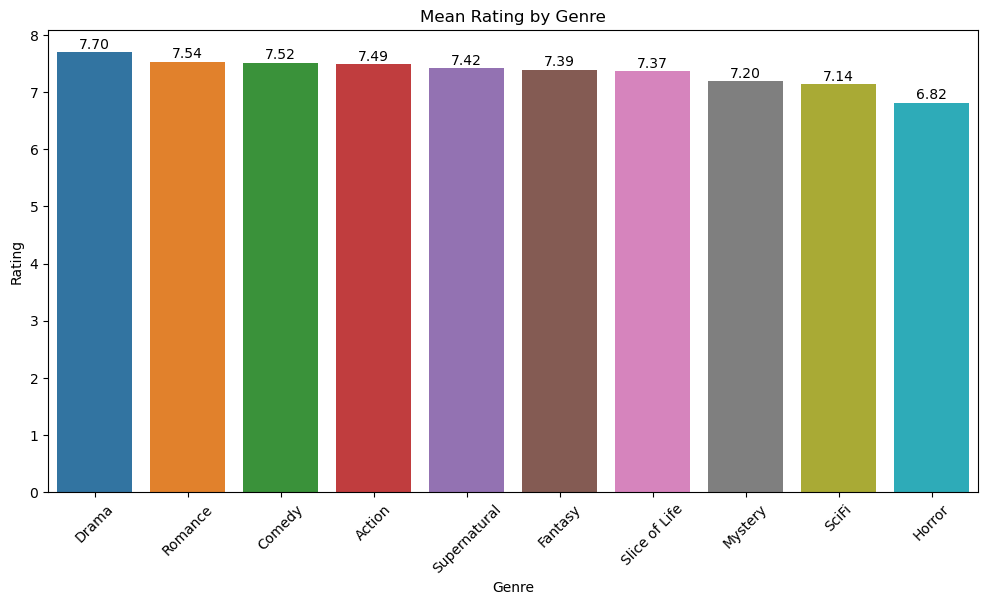

In [14]:
# Sort the DataFrame by 'Rating' in descending order
mean_numeric_data_by_genre = mean_numeric_data_by_genre.sort_values(by= 'Rating', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=mean_numeric_data_by_genre.index, y='Rating', data=mean_numeric_data_by_genre)
plt.xticks(rotation=45)
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.title('Mean Rating by Genre')

# Annotate the bars with the values (up to 2 decimal places) positioned higher
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() + 0.01), ha='center', va='bottom', fontsize=10, color='black')

plt.show()

As is evident from the 2 graphs, the most popular genres are Action, Drama, Comedy, and Romance. These are also the 4 most highly rated genres. On a personal note, I expected Slice of Life to be higher on both metrics. As a Slice of Life enjoyer, I was excited to train the model on this genre, so this hurts more than I thought it would :(

From this point on, the the EDA will focus on the exploring keywords used and themes in the top genres.

### Exploring keywords in the popular genres

As mentioned earlier, every manga tends to be a collection of genres and themes, rather than one single single genre, so it is expected that keywords and themes will be somewhat similar for these genre descriptions.

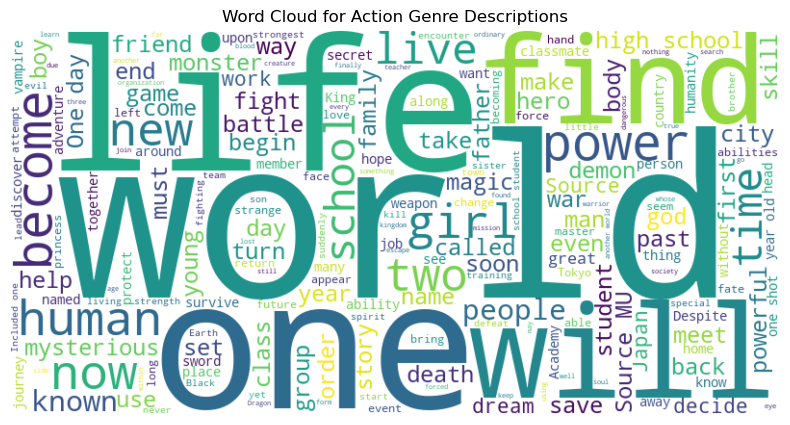

In [15]:
# Filter the DataFrame for the "Action" primary genre
action_df = df[df['Primary Genre'] == 'Action']

# Concatenate all descriptions in the filtered DataFrame
action_descriptions = " ".join(action_df['Description'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(action_descriptions)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Action Genre Descriptions")
plt.show()

### Interpretations and key themes in the 'action' wordcloud
The top keywords in the descriptions for action manga offer insights into the prevalent themes and elements within this genre. Phrases like "power," "battle," "monster," and "fight" underline the central focus on action and combat scenarios. The high frequency of words like "human," "girl," "boy," and "student" suggests that many action manga feature young protagonists who embark on thrilling adventures, which resonates with a young and dynamic audience. Themes of empowerment are prevalent, as indicated by "power," "become," and "powerful," reinforcing the idea of characters undergoing personal growth and development.

Furthermore, terms like "magic," "demon," and "god" hint at the supernatural and mythological elements often interwoven into the action manga narratives. These elements contribute to the creation of complex worlds and universes for characters to explore and engage with. The recurrence of words like "war," "battle," and "order" hints at the overarching conflict-driven narratives, where the struggle for control, dominance, or justice is a recurring theme. In summary, action manga descriptions primarily revolve around themes of personal growth, empowerment, and the enduring struggle between good and evil, often set against a backdrop of fantastical elements, reflecting the genre's appeal to fans of dynamic and adventurous storytelling.


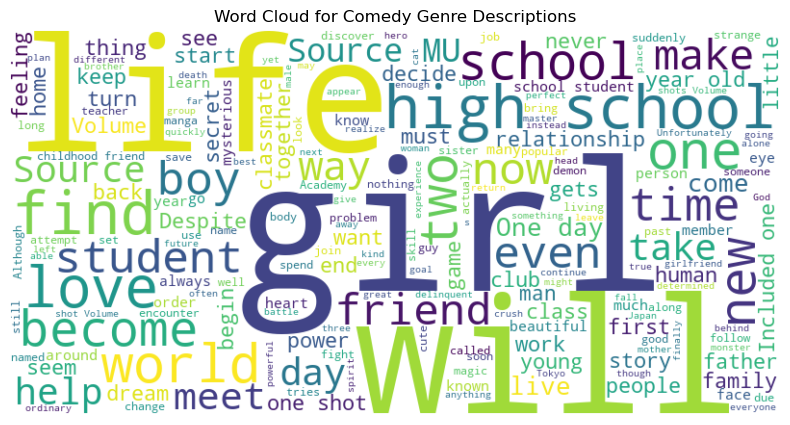

In [16]:
# Filter the DataFrame for the "Comedy" primary genre
comedy_df = df[df['Primary Genre'] == 'Comedy']

# Concatenate all descriptions in the filtered DataFrame
comedy_descriptions = " ".join(comedy_df['Description'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comedy_descriptions)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Comedy Genre Descriptions")
plt.show()

### Interpretations and key themes in the 'comedy' wordcloud

The prominent keywords in the descriptions of comedy manga shed light on the prevalent themes and humorous elements that define this genre. The high frequency of words like "girl," "high school," "boy," "student," and "school" suggests that comedy manga often unfolds within a school or adolescent setting, where the quirks and daily interactions of students become a rich source of comedic material. These keywords highlight the genre's ability to find humor in the mundane and universal experiences of youth. Furthermore, phrases like "love," "relationship," and "family" indicate that romance and interpersonal dynamics are recurring themes in comedy manga. The genre's humor often emerges from the complexities and idiosyncrasies of human relationships, making it relatable and appealing to readers.

In addition, the use of words such as "friend," "meet," and "help" underlines the significance of friendship and camaraderie as a central theme. Comedy manga often explores the bonds formed among characters and their amusing efforts to navigate life's challenges together. Words like "dream," "turn," and "want" hint at the genre's emphasis on characters' aspirations and ambitions, which often lead to comical and absurd situations. The prevalence of "one shot" and "year old" suggests that comedy manga may encompass standalone stories or humor centered around characters of various ages. In summary, comedy manga descriptions predominantly revolve around themes of school life, interpersonal relationships, dreams, and the universal human experiences, all framed within a lighthearted and humorous narrative, making it a popular genre among readers seeking laughter and relatable content.

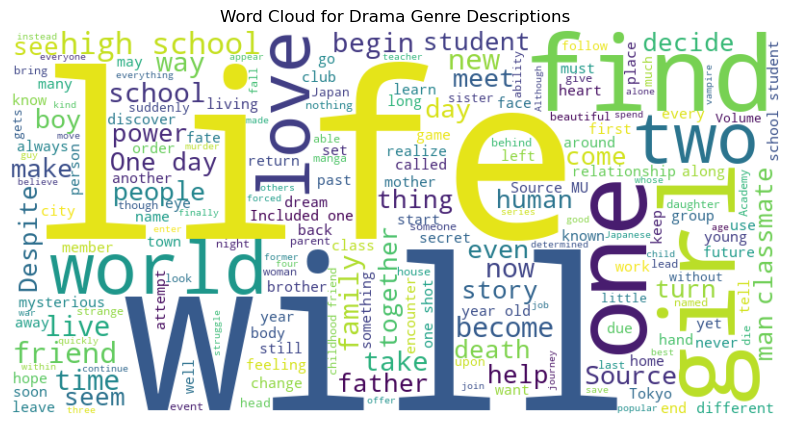

In [17]:
# Filter the DataFrame for the "Drama" primary genre
drama_df = df[df['Primary Genre'] == 'Drama']

# Concatenate all descriptions in the filtered DataFrame
drama_descriptions = " ".join(drama_df['Description'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(drama_descriptions)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Drama Genre Descriptions")
plt.show()

### Interpretations and key themes in the drama wordcloud
The keywords extracted from descriptions of drama manga point to the genre's profound exploration of life's complexities and human experiences. Words such as "life," "love," "family," and "relationship" suggest that drama manga delves deeply into the emotional and interpersonal aspects of its characters. These stories often revolve around the intricacies of human connections, be it romantic relationships or family dynamics. The prevalence of "high school" and "student" signifies that young characters grappling with adolescence and the challenges of school life are central to the genre's narratives. Drama manga frequently examines the personal growth and struggles of its characters during their formative years.

Moreover, the recurrence of words like "will," "find," and "begin" underscores the genre's focus on self-discovery, personal journeys, and new beginnings. The term "One day" implies a sense of pivotal moments in the characters' lives, suggesting that drama manga often portrays transformative events. The inclusion of words like "death," "mysterious," "secret," and "power" indicates that these narratives may incorporate elements of mystery and intrigue, adding depth to the emotional storytelling. The concept of "turn" and "decide" further reinforces the idea that drama manga frequently involves pivotal decisions and critical turning points in characters' lives. Collectively, drama manga weaves intricate tales of love, self-discovery, and growth within the backdrop of school life, offering readers emotionally resonant narratives that explore the complexities of human existence.

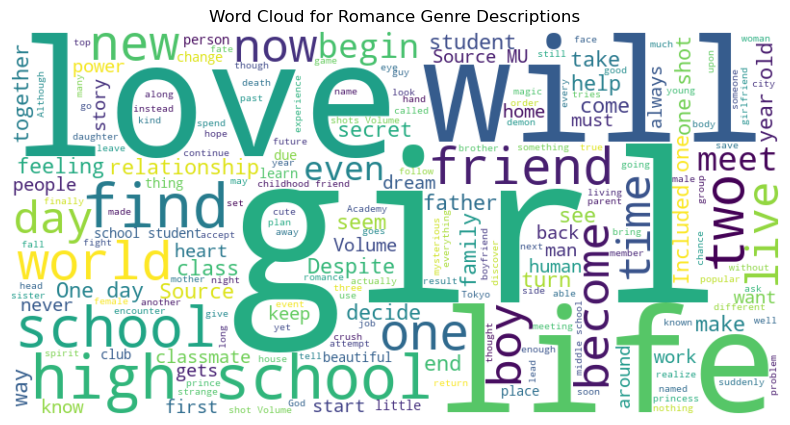

In [18]:
# Filter the DataFrame for the "Romance" primary genre
romance_df = df[df['Primary Genre'] == 'Romance']

# Concatenate all descriptions in the filtered DataFrame
romance_descriptions = " ".join(romance_df['Description'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(romance_descriptions)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Romance Genre Descriptions")
plt.show()

### Interpretation and key themes in the 'romance' wordcloud'
The prominent keywords extracted from romance manga descriptions emphasize the genre's primary focus on love, relationships, and personal journeys. Words such as "girl," "love," "life," and "will" underscore the central theme of romantic relationships and the emotional experiences of the characters. Romance manga often delves into the complexities of love, portraying the journey of individuals seeking and navigating romantic connections. "High school" and "school" suggest that these narratives frequently unfold in a school setting, emphasizing the exploration of young love and the challenges of adolescence.

The recurring themes of "friend," "begin," and "relationship" indicate the importance of interpersonal connections and the characters' quests to start new chapters in their lives, both romantically and socially. The term "One day" evokes the idea of serendipitous encounters and life-changing moments, a common trope in romance manga. The presence of "family" hints at the genre's exploration of familial dynamics, showcasing the impact of relationships beyond romantic love. Additionally, words like "secret" and "feeling" suggest an element of mystery and emotional depth within romance narratives. The word "end" might imply that romance manga also addresses the challenges and complications that relationships can face. Overall, romance manga encapsulates the essence of love, personal growth, and the intricate web of relationships, making it a genre that resonates with readers seeking heartfelt and emotionally charged stories.

### Conclusions from the Exploratory Data Analysis (EDA):

- **Outliers and Popularity Indicators:** The dataset contains outliers, particularly in the number of members column. These outliers are crucial indicators of a manga's popularity, especially for long-running and mainstream series. It's important to consider these outliers when assessing a manga's reach and commercial potential.
- **Correlation between Ratings and Members:** There is a modest positive correlation (correlation coefficient ≈ 0.39) between the number of members and the ratings. While a larger fanbase often correlates with higher ratings, this relationship varies across manga. Some niche series with lower membership still achieve high ratings. Audience preferences are diverse, and popularity doesn't always equate to higher ratings.
- **Genre Insights:** The EDA revealed that genres like "Action," "Drama," "Comedy," and "Romance" are the most popular and highly rated. It is essential to focus on these top genres when making recommendations to manga writers.

### Recommendations and action points:

- **Genre Selection:** Aspiring manga writers looking to break into the industry should consider focusing on genres like "Action," "Drama," "Comedy," and "Romance" due to their high popularity and average ratings. These genres have a broader audience base and the potential to attract a dedicated readership.
- **Leverage Emotional Storytelling:** Genres that focus on personal growth, interpersonal relationships, and emotional journeys, such as "Drama" and "Romance," are well-received. Aspiring writers should focus on creating relatable and emotionally resonant characters and stories.
- **Engage in World-Building:** Popular genres like "Action" often incorporate elements of fantasy, magic, and supernatural themes. Writers should invest in world-building and creative storytelling to transport readers to captivating and imaginative worlds.
- **Exploring Multiple Genres:** Don't be afraid to experiment with multiple genres or hybrid genres. Some of the most innovative and exciting manga emerge from creative genre combinations.

By following these conclusions and recommendations, manga writers can increase their chances of creating compelling and popular manga series that resonate with readers and stand out in the competitive world of manga.

In [51]:
# List of genres to filter
selected_genres = ["Action", "Comedy", "Romance", "Drama"]

# Create a new DataFrame containing only the selected genres
filtered_df = df[df['Primary Genre'].isin(selected_genres)]

# Save the filtered DataFrame as a CSV file
filtered_df.to_csv('filtered_manga_data.csv', index=False)

As stated above, we will only use the top 4 genres to train the model. With this, we come to the end of the cleaning and EDA part. The next part will focus on building a text generator and an image generator.